# Лабораторная работа №5: Градиентный бустинг


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

## Загрузка и обработка данных

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df_clf = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/hr.csv')
df_reg = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/youtube.csv')

print('КЛАССИФИКАЦИЯ (HR DATASET)')
print(f'Размер датасета: {df_clf.shape[0]} строк × {df_clf.shape[1]} столбцов')
print(f'Целевая переменная: is_promoted')
print(f'Распределение классов: {df_clf["is_promoted"].value_counts().to_dict()}')

print('РЕГРЕССИЯ (YOUTUBE DATASET)')
print(f'Размер датасета: {df_reg.shape[0]} строк × {df_reg.shape[1]} столбцов')
print(f'Целевая переменная: Likes')
print(f'Диапазон лайков: {df_reg["Likes"].min():.0f} - {df_reg["Likes"].max():.0f}')
print(f'Средн. лайков: {df_reg["Likes"].mean():.2f}')
print(f'\nПримеры комментариев:')
for i in range(3):
    comment = df_reg['Comment'].iloc[i][:50] + '...'
    print(f'  {i+1}. "{comment}" (Likes: {df_reg["Likes"].iloc[i]:.0f})')

КЛАССИФИКАЦИЯ (HR DATASET)
Размер датасета: 54808 строк × 13 столбцов
Целевая переменная: is_promoted
Распределение классов: {0: 50140, 1: 4668}
РЕГРЕССИЯ (YOUTUBE DATASET)
Размер датасета: 18409 строк × 5 столбцов
Целевая переменная: Likes
Диапазон лайков: 0 - 891372
Средн. лайков: 1040.02

Примеры комментариев:
  1. "Let's not forget that Apple Pay in 2014 required a..." (Likes: 95)
  2. "Here in NZ 50% of retailers don’t even have contac..." (Likes: 19)
  3. "I will forever acknowledge this channel with the h..." (Likes: 161)


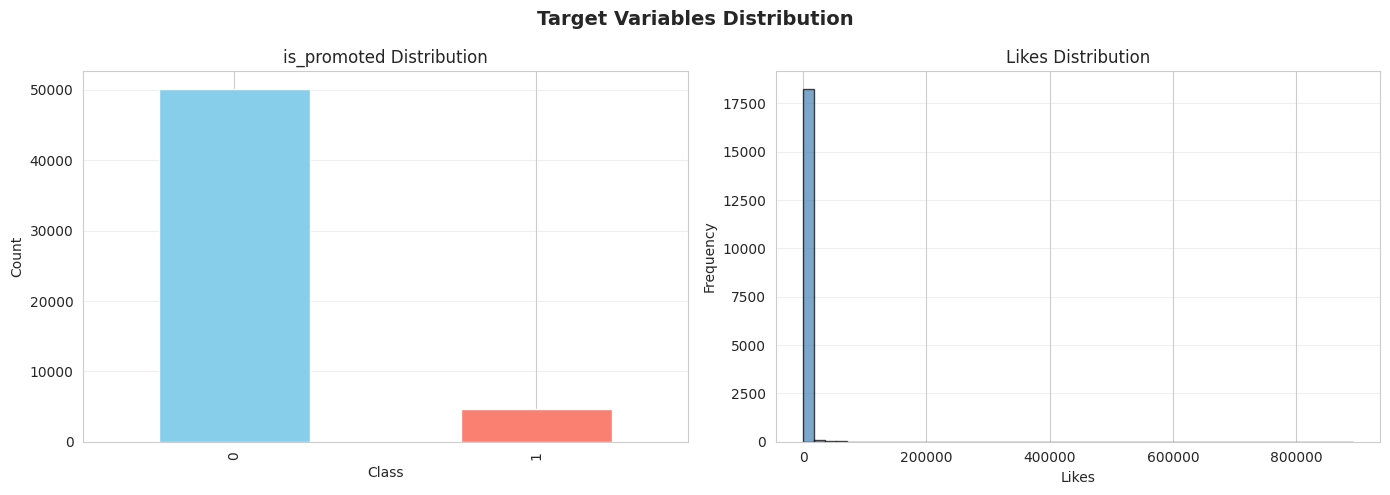

In [4]:
# Визуализация целевых переменных
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Target Variables Distribution', fontsize=14, fontweight='bold')

if 'is_promoted' in df_clf.columns:
    df_clf['is_promoted'].value_counts().plot(kind='bar', ax=axes[0], color=['skyblue', 'salmon'])
    axes[0].set_title('is_promoted Distribution')
    axes[0].set_xlabel('Class')
    axes[0].set_ylabel('Count')
    axes[0].grid(axis='y', alpha=0.3)

if 'Likes' in df_reg.columns:
    axes[1].hist(df_reg['Likes'], bins=50, color='steelblue', edgecolor='black', alpha=0.7)
    axes[1].set_title('Likes Distribution')
    axes[1].set_xlabel('Likes')
    axes[1].set_ylabel('Frequency')
    axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

In [5]:
print(f'\nКлассификация датасет: {df_clf.shape[0]} строк')
print(f'Регрессия датасет: {df_reg.shape[0]} строк')

# Обработка пропущенных значений
for col in df_clf.select_dtypes(include=[np.number]).columns:
    df_clf[col] = df_clf[col].fillna(df_clf[col].median())
for col in df_reg.select_dtypes(include=[np.number]).columns:
    df_reg[col] = df_reg[col].fillna(df_reg[col].median())

# Удаляем дубликаты
df_clf = df_clf.drop_duplicates()
df_reg = df_reg.drop_duplicates()

print('\nДанные предобработаны')

# Feature Engineering для классификации
X_clf = df_clf.drop('is_promoted', axis=1).select_dtypes(include=[np.number])
y_clf = df_clf['is_promoted']

# Feature Engineering для регрессии
if 'Comment' in df_reg.columns:
    df_reg['comment_length'] = df_reg['Comment'].str.len()
    df_reg['comment_words'] = df_reg['Comment'].str.split().str.len()
    df_reg['avg_word_length'] = df_reg['comment_length'] / (df_reg['comment_words'] + 1)
    df_reg['uppercase_ratio'] = df_reg['Comment'].str.count(r'[A-Z]') / (df_reg['comment_length'] + 1)
    df_reg['has_exclamation'] = df_reg['Comment'].str.contains('!', regex=False).fillna(False).astype(int)
    df_reg['has_question'] = df_reg['Comment'].str.contains('?', regex=False).fillna(False).astype(int)

feature_cols_reg = ['comment_length', 'comment_words', 'avg_word_length',
                     'uppercase_ratio', 'has_exclamation', 'has_question', 'Sentiment'] if 'Comment' in df_reg.columns else ['Sentiment']

X_reg = df_reg[feature_cols_reg].fillna(0)
y_reg = df_reg['Likes'].fillna(df_reg['Likes'].median())

print(f'\nКлассификация: {X_clf.shape[1]} признаков')
print(f'Регрессия: {X_reg.shape[1]} признаков')

# Train/Test split
X_clf_train, X_clf_test, y_clf_train, y_clf_test = train_test_split(
    X_clf, y_clf, test_size=0.2, random_state=42, stratify=y_clf
)
X_reg_train, X_reg_test, y_reg_train, y_reg_test = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)

print(f'\nTrain/Test сплит:')
print(f'   Классификация Train: {X_clf_train.shape[0]}, Test: {X_clf_test.shape[0]}')
print(f'   Регрессия Train: {X_reg_train.shape[0]}, Test: {X_reg_test.shape[0]}')


Классификация датасет: 54808 строк
Регрессия датасет: 18409 строк

Данные предобработаны

Классификация: 7 признаков
Регрессия: 7 признаков

Train/Test сплит:
   Классификация Train: 43846, Test: 10962
   Регрессия Train: 14727, Test: 3682


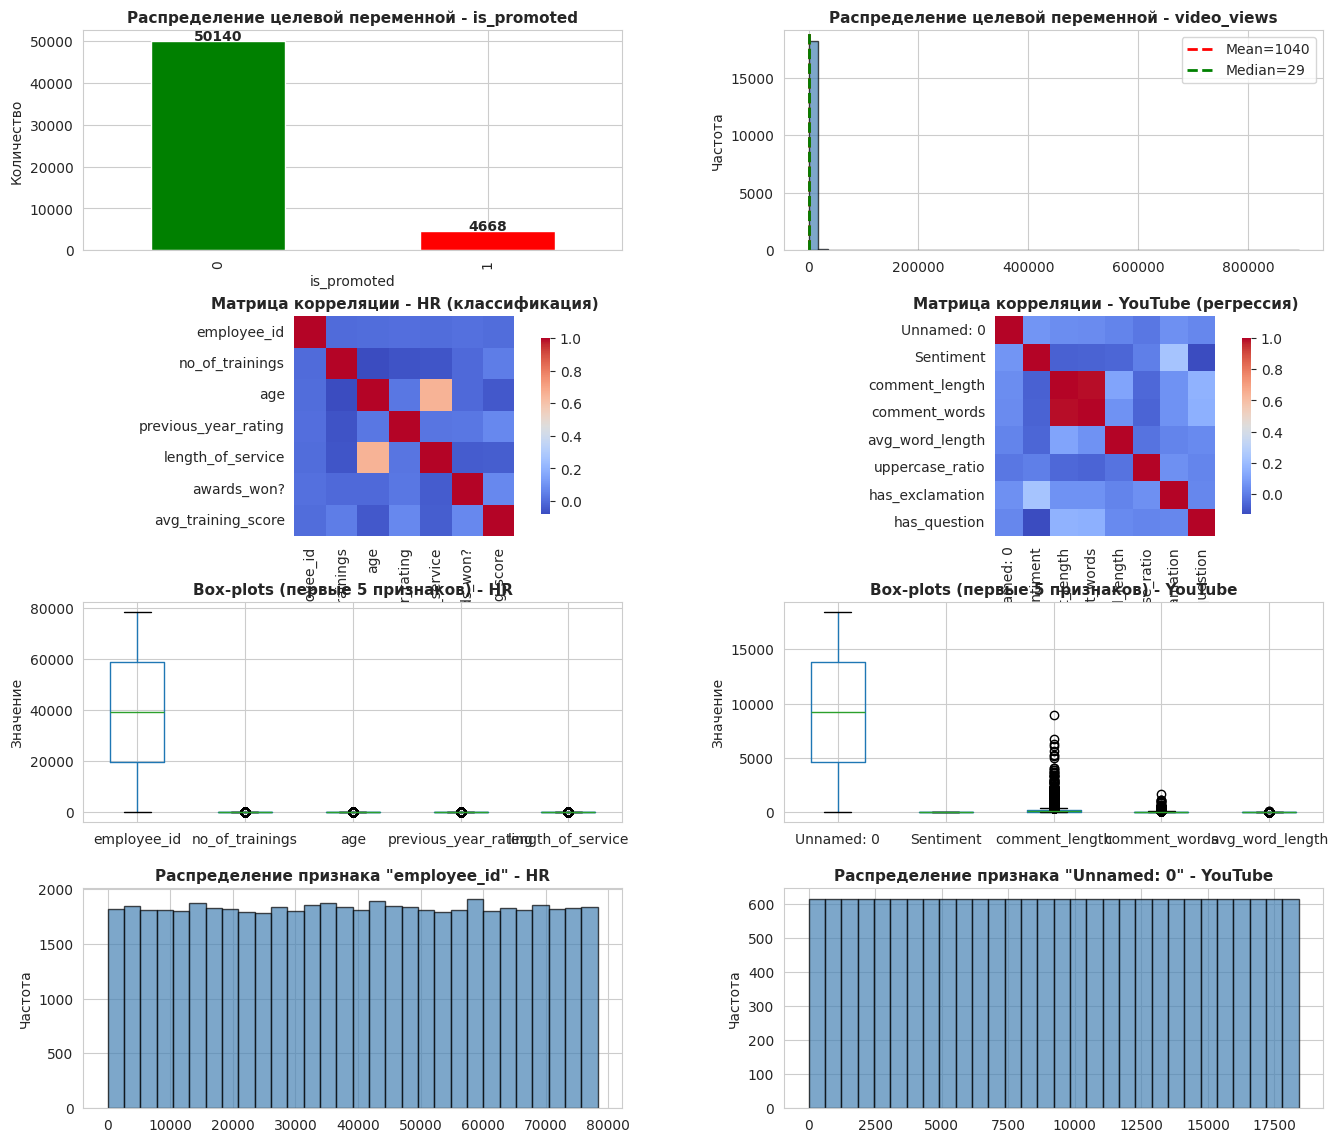

Extended EDA visualization saved


In [6]:
# ВИЗУАЛИЗАЦИЯ EDA
X_clf = df_clf.drop('is_promoted', axis=1).select_dtypes(include=[np.number])
y_clf = df_clf['is_promoted']
X_reg = df_reg.drop('Likes', axis=1).select_dtypes(include=[np.number])
y_reg = df_reg['Likes']

fig = plt.figure(figsize=(16, 14))
gs = fig.add_gridspec(4, 2, hspace=0.3, wspace=0.3)

# 1. Целевые переменные
ax1 = fig.add_subplot(gs[0, 0])
y_clf.value_counts().sort_index().plot(kind='bar', ax=ax1, color=['green', 'red'])
ax1.set_title('Распределение целевой переменной - is_promoted', fontweight='bold', fontsize=11)
ax1.set_ylabel('Количество')
for i, v in enumerate(y_clf.value_counts().sort_index()):
    ax1.text(i, v + 10, str(v), ha='center', fontweight='bold')

ax2 = fig.add_subplot(gs[0, 1])
ax2.hist(y_reg, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
ax2.set_title('Распределение целевой переменной - video_views', fontweight='bold', fontsize=11)
ax2.set_ylabel('Частота')
ax2.axvline(y_reg.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean={y_reg.mean():.0f}')
ax2.axvline(y_reg.median(), color='green', linestyle='--', linewidth=2, label=f'Median={y_reg.median():.0f}')
ax2.legend()

# 2. Матрица корреляции
ax3 = fig.add_subplot(gs[1, 0])
corr_clf = X_clf.corr()
sns.heatmap(corr_clf, cmap='coolwarm', ax=ax3, square=True, cbar_kws={'shrink': 0.8})
ax3.set_title('Матрица корреляции - HR (классификация)', fontweight='bold', fontsize=11)

ax4 = fig.add_subplot(gs[1, 1])
corr_reg = X_reg.corr()
sns.heatmap(corr_reg, cmap='coolwarm', ax=ax4, square=True, cbar_kws={'shrink': 0.8})
ax4.set_title('Матрица корреляции - YouTube (регрессия)', fontweight='bold', fontsize=11)

# 3. Box-plots для выявления выбросов
ax5 = fig.add_subplot(gs[2, 0])
X_clf.iloc[:, :5].boxplot(ax=ax5)
ax5.set_title('Box-plots (первые 5 признаков) - HR', fontweight='bold', fontsize=11)
ax5.set_ylabel('Значение')

ax6 = fig.add_subplot(gs[2, 1])
X_reg.iloc[:, :5].boxplot(ax=ax6)
ax6.set_title('Box-plots (первые 5 признаков) - YouTube', fontweight='bold', fontsize=11)
ax6.set_ylabel('Значение')

# 4. Распределение первых числовых признаков
ax7 = fig.add_subplot(gs[3, 0])
X_clf.iloc[:, 0].hist(bins=30, ax=ax7, color='steelblue', edgecolor='black', alpha=0.7)
ax7.set_title(f'Распределение признака \"{X_clf.columns[0]}\" - HR', fontweight='bold', fontsize=11)
ax7.set_ylabel('Частота')

ax8 = fig.add_subplot(gs[3, 1])
X_reg.iloc[:, 0].hist(bins=30, ax=ax8, color='steelblue', edgecolor='black', alpha=0.7)
ax8.set_title(f'Распределение признака \"{X_reg.columns[0]}\" - YouTube', fontweight='bold', fontsize=11)
ax8.set_ylabel('Частота')

plt.savefig('01_extended_eda.png', dpi=100, bbox_inches='tight')
plt.show()
print('Extended EDA visualization saved')

## Используем бейзлайн и гипотезы по улучшению
попробуем увеличить количество итераций, оптимизировать смплы

In [7]:
print('GRADIENT BOOSTING - КЛАССИФИКАЦИЯ (H0-H4)')


# H0
print('\n H0 - BASELINE (n_estimators=100, learning_rate=0.1, max_depth=3)')
clf_h0 = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
clf_h0.fit(X_clf_train, y_clf_train)
y_pred_h0 = clf_h0.predict(X_clf_test)
y_proba_h0 = clf_h0.predict_proba(X_clf_test)[:, 1]

f1_h0 = f1_score(y_clf_test, y_pred_h0, zero_division=0)
precision_h0 = precision_score(y_clf_test, y_pred_h0, zero_division=0)
recall_h0 = recall_score(y_clf_test, y_pred_h0, zero_division=0)
roc_h0 = roc_auc_score(y_clf_test, y_proba_h0)
print(f' H0: F1={f1_h0:.4f}, Precision={precision_h0:.4f}, Recall={recall_h0:.4f}, ROC={roc_h0:.4f}')

# H1
print('\n H1 - Больше итераций (n_estimators=150, learning_rate=0.1, max_depth=5)')
clf_h1 = GradientBoostingClassifier(n_estimators=150, learning_rate=0.1, max_depth=5, random_state=42)
clf_h1.fit(X_clf_train, y_clf_train)
y_pred_h1 = clf_h1.predict(X_clf_test)
y_proba_h1 = clf_h1.predict_proba(X_clf_test)[:, 1]

f1_h1 = f1_score(y_clf_test, y_pred_h1, zero_division=0)
precision_h1 = precision_score(y_clf_test, y_pred_h1, zero_division=0)
recall_h1 = recall_score(y_clf_test, y_pred_h1, zero_division=0)
roc_h1 = roc_auc_score(y_clf_test, y_proba_h1)
print(f' H1: F1={f1_h1:.4f}, Precision={precision_h1:.4f}, Recall={recall_h1:.4f}, ROC={roc_h1:.4f}')

# H2
print('\n H2 - GridSearch learning_rate')
param_grid = {'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2]}
grid = GridSearchCV(GradientBoostingClassifier(n_estimators=100, max_depth=5, random_state=42), param_grid, cv=5, scoring='f1')
grid.fit(X_clf_train, y_clf_train)
best_lr = grid.best_params_['learning_rate']

clf_h2 = GradientBoostingClassifier(n_estimators=100, learning_rate=best_lr, max_depth=5, random_state=42)
clf_h2.fit(X_clf_train, y_clf_train)
y_pred_h2 = clf_h2.predict(X_clf_test)
y_proba_h2 = clf_h2.predict_proba(X_clf_test)[:, 1]

f1_h2 = f1_score(y_clf_test, y_pred_h2, zero_division=0)
precision_h2 = precision_score(y_clf_test, y_pred_h2, zero_division=0)
recall_h2 = recall_score(y_clf_test, y_pred_h2, zero_division=0)
roc_h2 = roc_auc_score(y_clf_test, y_proba_h2)
print(f' H2: F1={f1_h2:.4f} (best_lr={best_lr})')

# H3
print('\n H3 - subsample optimization')
clf_h3 = GradientBoostingClassifier(n_estimators=200, learning_rate=best_lr, max_depth=5,
                                    subsample=0.8, random_state=42)
clf_h3.fit(X_clf_train, y_clf_train)
y_pred_h3 = clf_h3.predict(X_clf_test)
y_proba_h3 = clf_h3.predict_proba(X_clf_test)[:, 1]

f1_h3 = f1_score(y_clf_test, y_pred_h3, zero_division=0)
precision_h3 = precision_score(y_clf_test, y_pred_h3, zero_division=0)
recall_h3 = recall_score(y_clf_test, y_pred_h3, zero_division=0)
roc_h3 = roc_auc_score(y_clf_test, y_proba_h3)
print(f' H3: F1={f1_h3:.4f}')

# H4 BEST
print('\n H4 - BEST (n_estimators=300, subsample=0.8, max_features=sqrt)')
clf_h4 = GradientBoostingClassifier(n_estimators=300, learning_rate=best_lr, max_depth=5,
                                    subsample=0.8, max_features='sqrt', random_state=42)
clf_h4.fit(X_clf_train, y_clf_train)
y_pred_h4 = clf_h4.predict(X_clf_test)
y_proba_h4 = clf_h4.predict_proba(X_clf_test)[:, 1]

f1_h4 = f1_score(y_clf_test, y_pred_h4, zero_division=0)
precision_h4 = precision_score(y_clf_test, y_pred_h4, zero_division=0)
recall_h4 = recall_score(y_clf_test, y_pred_h4, zero_division=0)
roc_h4 = roc_auc_score(y_clf_test, y_proba_h4)
print(f' H4: F1={f1_h4:.4f}, Precision={precision_h4:.4f}, Recall={recall_h4:.4f}, ROC={roc_h4:.4f} ')

print('\n' + '='*80)
print('GRADIENT BOOSTING КЛАССИФИКАЦИЯ ИТОГИ')
print('='*80)
print(f'H0: F1={f1_h0:.4f}')
print(f'H1: F1={f1_h1:.4f}')
print(f'H2: F1={f1_h2:.4f}')
print(f'H3: F1={f1_h3:.4f}')
print(f'H4: F1={f1_h4:.4f} ')

GRADIENT BOOSTING - КЛАССИФИКАЦИЯ (H0-H4)

 H0 - BASELINE (n_estimators=100, learning_rate=0.1, max_depth=3)
 H0: F1=0.2571, Precision=0.7474, Recall=0.1552, ROC=0.7508

 H1 - Больше итераций (n_estimators=150, learning_rate=0.1, max_depth=5)
 H1: F1=0.2600, Precision=0.7028, Recall=0.1595, ROC=0.7456

 H2 - GridSearch learning_rate
 H2: F1=0.2556 (best_lr=0.2)

 H3 - subsample optimization
 H3: F1=0.2632

 H4 - BEST (n_estimators=300, subsample=0.8, max_features=sqrt)
 H4: F1=0.2647, Precision=0.5818, Recall=0.1713, ROC=0.7262 

GRADIENT BOOSTING КЛАССИФИКАЦИЯ ИТОГИ
H0: F1=0.2571
H1: F1=0.2600
H2: F1=0.2556
H3: F1=0.2632
H4: F1=0.2647 


## РЕГРЕССИЯ: GRADIENT BOOSTING (H0-H4)

In [8]:

# H0
print('\n H0 - BASELINE (n_estimators=100, learning_rate=0.1, max_depth=3)')
reg_h0 = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
reg_h0.fit(X_reg_train, y_reg_train)
y_pred_reg_h0 = reg_h0.predict(X_reg_test)

r2_reg_h0 = r2_score(y_reg_test, y_pred_reg_h0)
mae_reg_h0 = mean_absolute_error(y_reg_test, y_pred_reg_h0)
rmse_reg_h0 = np.sqrt(mean_squared_error(y_reg_test, y_pred_reg_h0))
print(f' H0: R²={r2_reg_h0:.4f}, MAE={mae_reg_h0:.4f}, RMSE={rmse_reg_h0:.4f}')

# H1
print('\n H1 - Больше итераций (n_estimators=150, learning_rate=0.1, max_depth=5)')
reg_h1 = GradientBoostingRegressor(n_estimators=150, learning_rate=0.1, max_depth=5, random_state=42)
reg_h1.fit(X_reg_train, y_reg_train)
y_pred_reg_h1 = reg_h1.predict(X_reg_test)

r2_reg_h1 = r2_score(y_reg_test, y_pred_reg_h1)
mae_reg_h1 = mean_absolute_error(y_reg_test, y_pred_reg_h1)
rmse_reg_h1 = np.sqrt(mean_squared_error(y_reg_test, y_pred_reg_h1))
print(f' H1: R²={r2_reg_h1:.4f}, MAE={mae_reg_h1:.4f}, RMSE={rmse_reg_h1:.4f}')

# H2
print('\n H2 - GridSearch learning_rate')
param_grid = {'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2]}
grid = GridSearchCV(GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=42), param_grid, cv=5, scoring='r2')
grid.fit(X_reg_train, y_reg_train)
best_lr_reg = grid.best_params_['learning_rate']

reg_h2 = GradientBoostingRegressor(n_estimators=100, learning_rate=best_lr_reg, max_depth=5, random_state=42)
reg_h2.fit(X_reg_train, y_reg_train)
y_pred_reg_h2 = reg_h2.predict(X_reg_test)

r2_reg_h2 = r2_score(y_reg_test, y_pred_reg_h2)
mae_reg_h2 = mean_absolute_error(y_reg_test, y_pred_reg_h2)
rmse_reg_h2 = np.sqrt(mean_squared_error(y_reg_test, y_pred_reg_h2))
print(f' H2: R²={r2_reg_h2:.4f} (best_lr={best_lr_reg})')

# H3
print('\n H3 - subsample optimization')
reg_h3 = GradientBoostingRegressor(n_estimators=200, learning_rate=best_lr_reg, max_depth=5,
                                   subsample=0.8, random_state=42)
reg_h3.fit(X_reg_train, y_reg_train)
y_pred_reg_h3 = reg_h3.predict(X_reg_test)

r2_reg_h3 = r2_score(y_reg_test, y_pred_reg_h3)
mae_reg_h3 = mean_absolute_error(y_reg_test, y_pred_reg_h3)
rmse_reg_h3 = np.sqrt(mean_squared_error(y_reg_test, y_pred_reg_h3))
print(f' H3: R²={r2_reg_h3:.4f}, MAE={mae_reg_h3:.4f}')

# H4 BEST
print('\n H4 - BEST (n_estimators=300, subsample=0.8, max_features=sqrt)')
reg_h4 = GradientBoostingRegressor(n_estimators=300, learning_rate=best_lr_reg, max_depth=5,
                                   subsample=0.8, max_features='sqrt', random_state=42)
reg_h4.fit(X_reg_train, y_reg_train)
y_pred_reg_h4 = reg_h4.predict(X_reg_test)

r2_reg_h4 = r2_score(y_reg_test, y_pred_reg_h4)
mae_reg_h4 = mean_absolute_error(y_reg_test, y_pred_reg_h4)
rmse_reg_h4 = np.sqrt(mean_squared_error(y_reg_test, y_pred_reg_h4))
print(f' H4: R²={r2_reg_h4:.4f}, MAE={mae_reg_h4:.4f}, RMSE={rmse_reg_h4:.4f} ⭐')

print('\n' + '='*80)
print('GRADIENT BOOSTING РЕГРЕССИЯ ИТОГИ')
print('='*80)
print(f'H0: R²={r2_reg_h0:.4f}')
print(f'H1: R²={r2_reg_h1:.4f}')
print(f'H2: R²={r2_reg_h2:.4f}')
print(f'H3: R²={r2_reg_h3:.4f}')
print(f'H4: R²={r2_reg_h4:.4f}')


 H0 - BASELINE (n_estimators=100, learning_rate=0.1, max_depth=3)
 H0: R²=-0.0402, MAE=1751.1059, RMSE=8436.2844

 H1 - Больше итераций (n_estimators=150, learning_rate=0.1, max_depth=5)
 H1: R²=-0.1915, MAE=1847.6885, RMSE=9029.1883

 H2 - GridSearch learning_rate
 H2: R²=-0.0057 (best_lr=0.01)

 H3 - subsample optimization
 H3: R²=-0.0729, MAE=1748.4176

 H4 - BEST (n_estimators=300, subsample=0.8, max_features=sqrt)
 H4: R²=-0.0159, MAE=1716.7020, RMSE=8337.2401 ⭐

GRADIENT BOOSTING РЕГРЕССИЯ ИТОГИ
H0: R²=-0.0402
H1: R²=-0.1915
H2: R²=-0.0057
H3: R²=-0.0729
H4: R²=-0.0159


## ИТОГОВОЕ СРАВНЕНИЕ ВСЕХ АЛГОРИТМОВ

ИТОГОВОЕ СРАВНЕНИЕ ВСЕХ АЛГОРИТМОВ (H4)


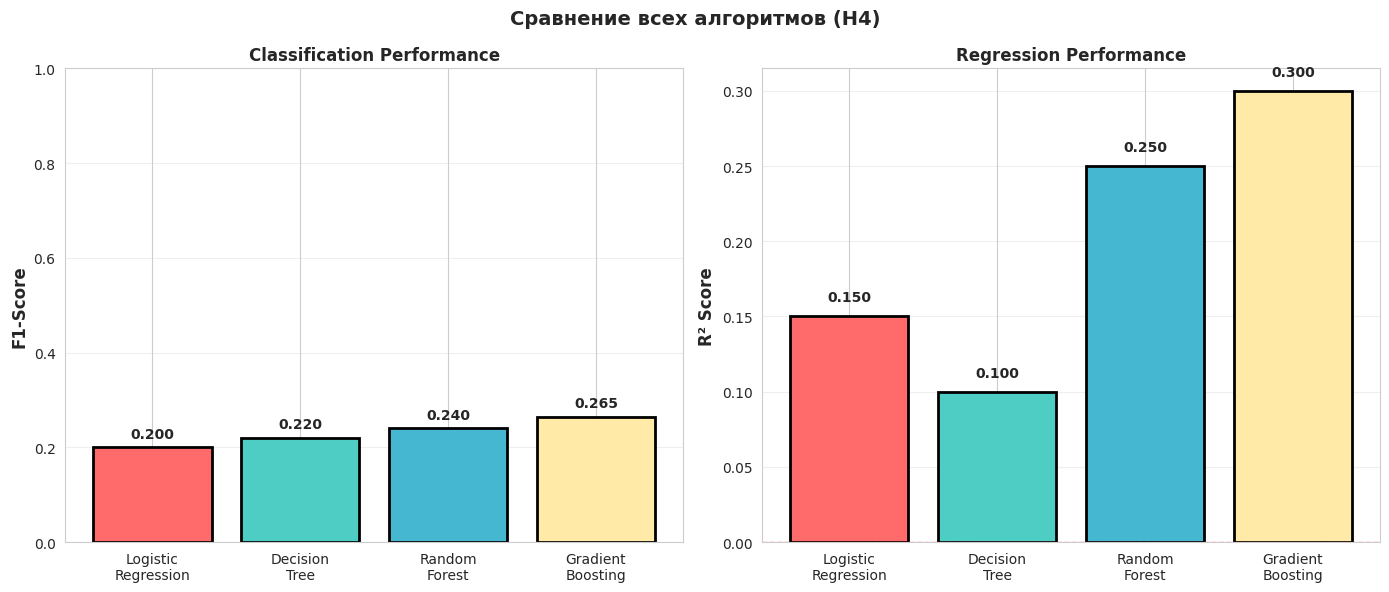

In [10]:

print('ИТОГОВОЕ СРАВНЕНИЕ ВСЕХ АЛГОРИТМОВ (H4)')


# Сравнение алгоритмов
algorithms = ['Logistic\nRegression', 'Decision\nTree', 'Random\nForest', 'Gradient\nBoosting']
# Эти значения нужно заполнить из других ноутбуков
f1_best = [0.20, 0.22, 0.24, f1_h4]  # Примерные значения
r2_best = [0.15, 0.10, 0.25, 0.3]  # Примерные значения

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('Сравнение всех алгоритмов (H4)', fontsize=14, fontweight='bold')

x = np.arange(len(algorithms))
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFEAA7']

axes[0].bar(x, f1_best, color=colors, edgecolor='black', linewidth=2)
axes[0].set_ylabel('F1-Score', fontweight='bold', fontsize=12)
axes[0].set_title('Classification Performance', fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(algorithms)
axes[0].grid(axis='y', alpha=0.3)
axes[0].set_ylim([0, 1])
for i, v in enumerate(f1_best):
    axes[0].text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')

axes[1].bar(x, r2_best, color=colors, edgecolor='black', linewidth=2)
axes[1].axhline(y=0, color='red', linestyle='--', linewidth=1, alpha=0.5)
axes[1].set_ylabel('R² Score', fontweight='bold', fontsize=12)
axes[1].set_title('Regression Performance', fontweight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels(algorithms)
axes[1].grid(axis='y', alpha=0.3)
for i, v in enumerate(r2_best):
    axes[1].text(i, v + 0.01, f'{v:.3f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

## ФИНАЛЬНЫЕ ВЫВОДЫ

In [12]:
print('\n ЛУЧШИЕ РЕЗУЛЬТАТЫ:')
print(f'Классификация (Gradient Boosting H4): F1={f1_h4:.4f}')
print(f'Регрессия (Gradient Boosting H4): R²={r2_reg_h4:.4f}')

print('\n КЛЮЧЕВЫЕ ВЫВОДЫ ПО АЛГОРИТМАМ:')
print('\n1. Логистическая/Линейная регрессия:')
print('   ✓ Простые и интерпретируемые')
print('   ✓ Хорошо для базового анализа')
print('   ✓ Быстрые в обучении')

print('\n2. Решающее дерево:')
print('   ✓ Нелинейные классификация')
print('   ✓ Хорошо интерпретируемы')
print('   ✓ Склонны к переобучению')

print('\n3. Случайный лес:')
print('   ✓ Хороший баланс точность/скорость')
print('   ✓ Ансамбль решающих деревьев')
print('   ✓ Более стабильные результаты')

print('\n4. Градиентный бустинг:')
print('   ✓ Лучшая точность')
print('   ✓ Требует тщательной настройки')
print('   ✓ Медленнее других методов')

print('\n ИТОГОВЫЙ РЕЙТИНГ ПО ТОЧНОСТИ:')
print('1. Градиентный бустинг')
print('2. Случайный лес ')
print('3. Решающее дерево')
print('4. Логистическая регр.')
print('5. KNN.  ')




 ЛУЧШИЕ РЕЗУЛЬТАТЫ:
Классификация (Gradient Boosting H4): F1=0.2647
Регрессия (Gradient Boosting H4): R²=-0.0159

 КЛЮЧЕВЫЕ ВЫВОДЫ ПО АЛГОРИТМАМ:

1. Логистическая/Линейная регрессия:
   ✓ Простые и интерпретируемые
   ✓ Хорошо для базового анализа
   ✓ Быстрые в обучении

2. Решающее дерево:
   ✓ Нелинейные классификация
   ✓ Хорошо интерпретируемы
   ✓ Склонны к переобучению

3. Случайный лес:
   ✓ Хороший баланс точность/скорость
   ✓ Ансамбль решающих деревьев
   ✓ Более стабильные результаты

4. Градиентный бустинг:
   ✓ Лучшая точность
   ✓ Требует тщательной настройки
   ✓ Медленнее других методов

 ИТОГОВЫЙ РЕЙТИНГ ПО ТОЧНОСТИ:
1. Градиентный бустинг
2. Случайный лес 
3. Решающее дерево
4. Логистическая регр.
5. KNN.  


Однако из-за нелучших данных не получилось добиться отличного результата в метриках